In [1]:
import os
import time
import pathlib
import itertools
from PIL import Image

# import data handling tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,GlobalAveragePooling2D, Dense, Activation, Dropout, BatchNormalization


%matplotlib inline

np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools


from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report
import tensorflow_hub as hub



# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/C1_data/Training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 84 images belonging to 2 classes.


In [5]:
train_data_dir = '/content/drive/MyDrive/C1_data/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [6]:
# Generate data paths with labels
test_data_dir = '/content/drive/MyDrive/C1_data/Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [7]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels',
                                       target_size= img_size, class_mode= 'categorical',
                                       color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels',
                                      target_size= img_size, class_mode= 'categorical',
                                      color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 84 validated image filenames belonging to 2 classes.
Found 204 validated image filenames belonging to 2 classes.


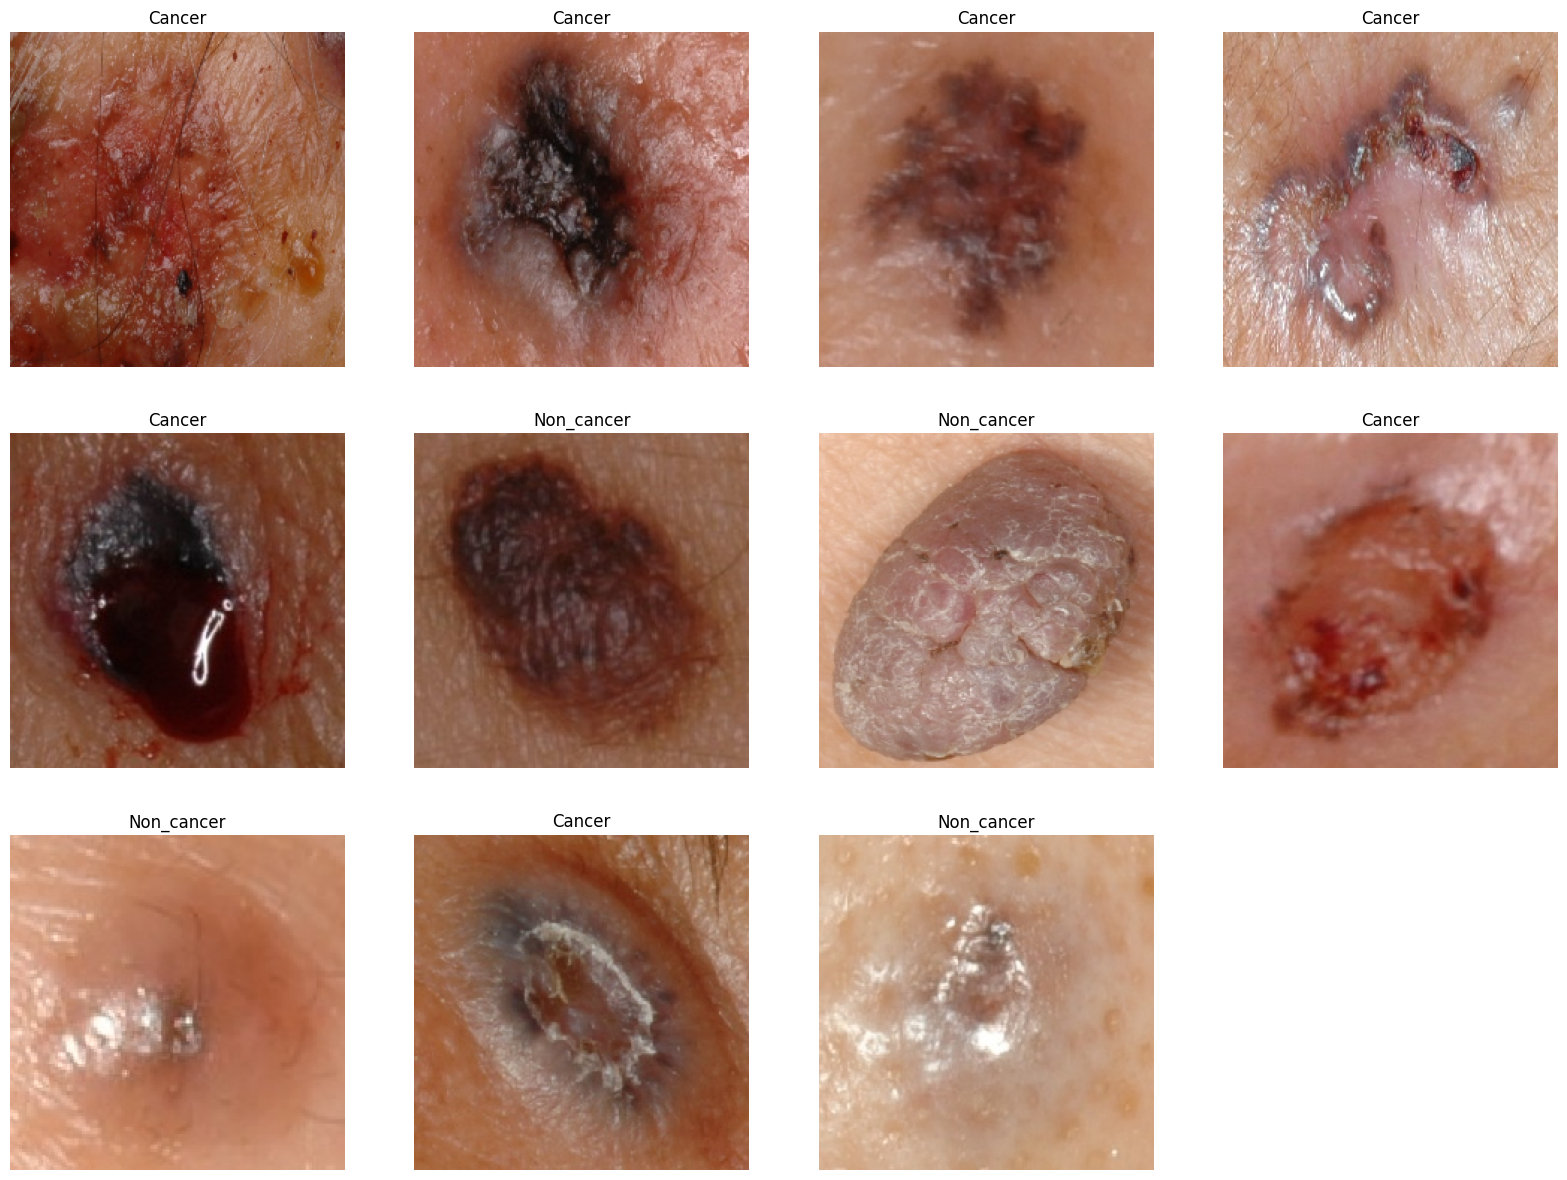

In [8]:
g_dict = train_gen.class_indices  # defines dictionary {'class': index}
classes = list(g_dict.keys())  # defines list of dictionary's keys (classes), class names : string
images, labels = next(train_gen)  # get a batch size samples from the generator

plt.figure(figsize=(20, 20))

for i in range(11):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255  # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    if classes[index] == 'Non_Cancer':
        class_name = 'non_cancer'

    elif classes[index] == 'malignant':
        class_name = 'cancer'
    else:
        class_name = classes[index]
    plt.title(class_name, fontsize=12)
    plt.axis('off')
plt.show()

In [12]:
model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (224,224,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block 1
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 2
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 3
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fully Connected layers
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(2,activation='sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,268,290 (73.50 MB)

 Trainable params: 19,266,306 (73.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [13]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [14]:
history1 = model.fit(train_gen,
                    validation_data = test_gen,
                     batch_size = 64,
                    epochs = 50)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 57s 8s/step - accuracy: 0.6902 - loss: 0.8828 - val_accuracy: 0.2059 - val_loss: 53.9060
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.7484 - loss: 0.6513 - val_accuracy: 0.2059 - val_loss: 41.0382
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - accuracy: 0.8941 - loss: 0.3069 - val_accuracy: 0.2059 - val_loss: 26.7063
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.9483 - loss: 0.2159 - val_accuracy: 0.2304 - val_loss: 5.9408
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 292ms/step - accuracy: 0.8210 - loss: 0.4778 - val_accuracy: 0.2255 - val_loss: 4.6405
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 305ms/step - accuracy: 0.8824 - loss: 0.3207 - val_accuracy: 0.2304 - val_loss: 5.1493
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - accuracy: 0.9539 - loss: 0.2022 - val_accuracy: 0.2451 - val_loss: 4.6571
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.9838 - loss: 0.0979 - val_accuracy: 0.2647 - val_loss

In [15]:
Er = []
np.append(history1, Er)

array([<keras.src.callbacks.history.History object at 0x7cc9aecc5c50>],
      dtype=object)

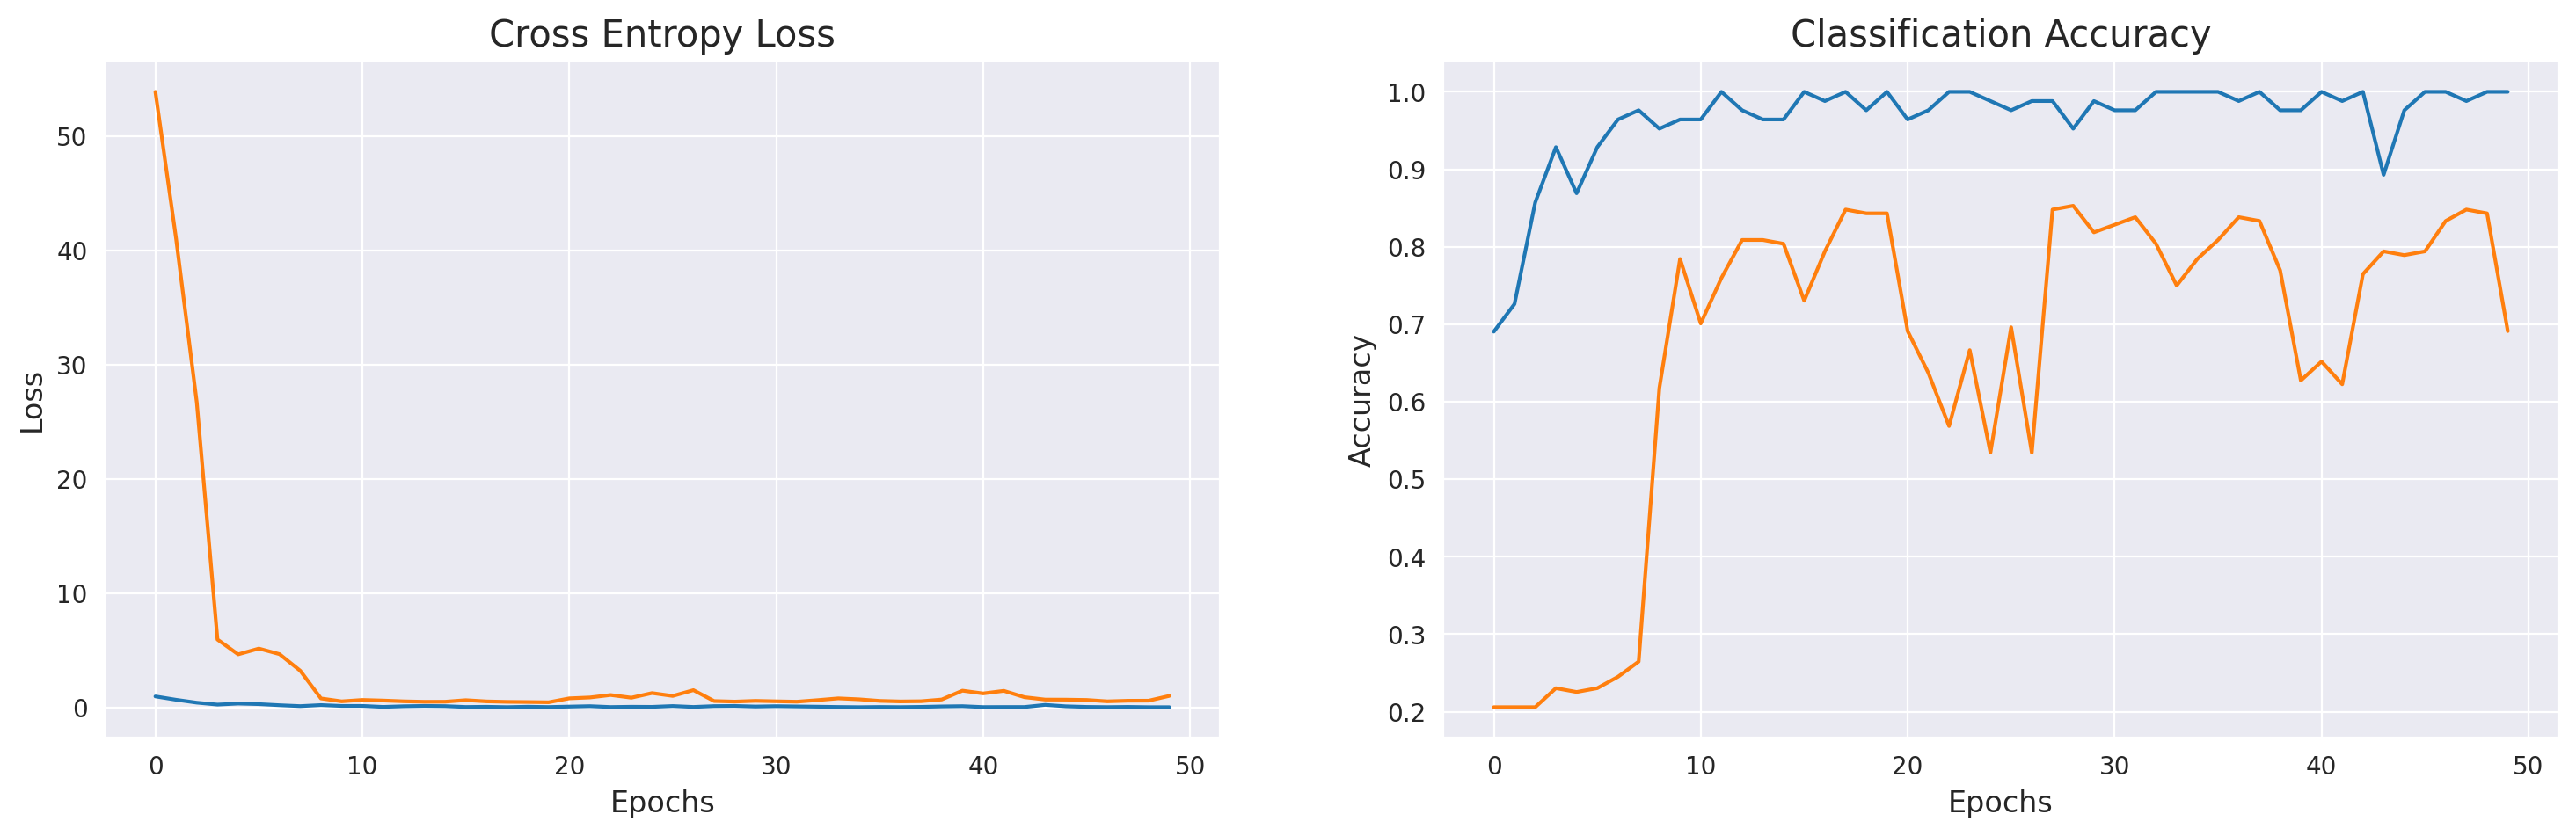

In [16]:
error = pd.DataFrame(history1.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

In [17]:
# Evaluvate for train generator
loss,acc = model.evaluate(train_gen)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.7207 - loss: 0.5682
The accuracy of the model for training data is: 73.8095223903656
The Loss of the model for training data is: 0.5195513367652893


In [18]:
Er = []
np.append(history1, Er)

array([<keras.src.callbacks.history.History object at 0x7cc9aecc5c50>],
      dtype=object)

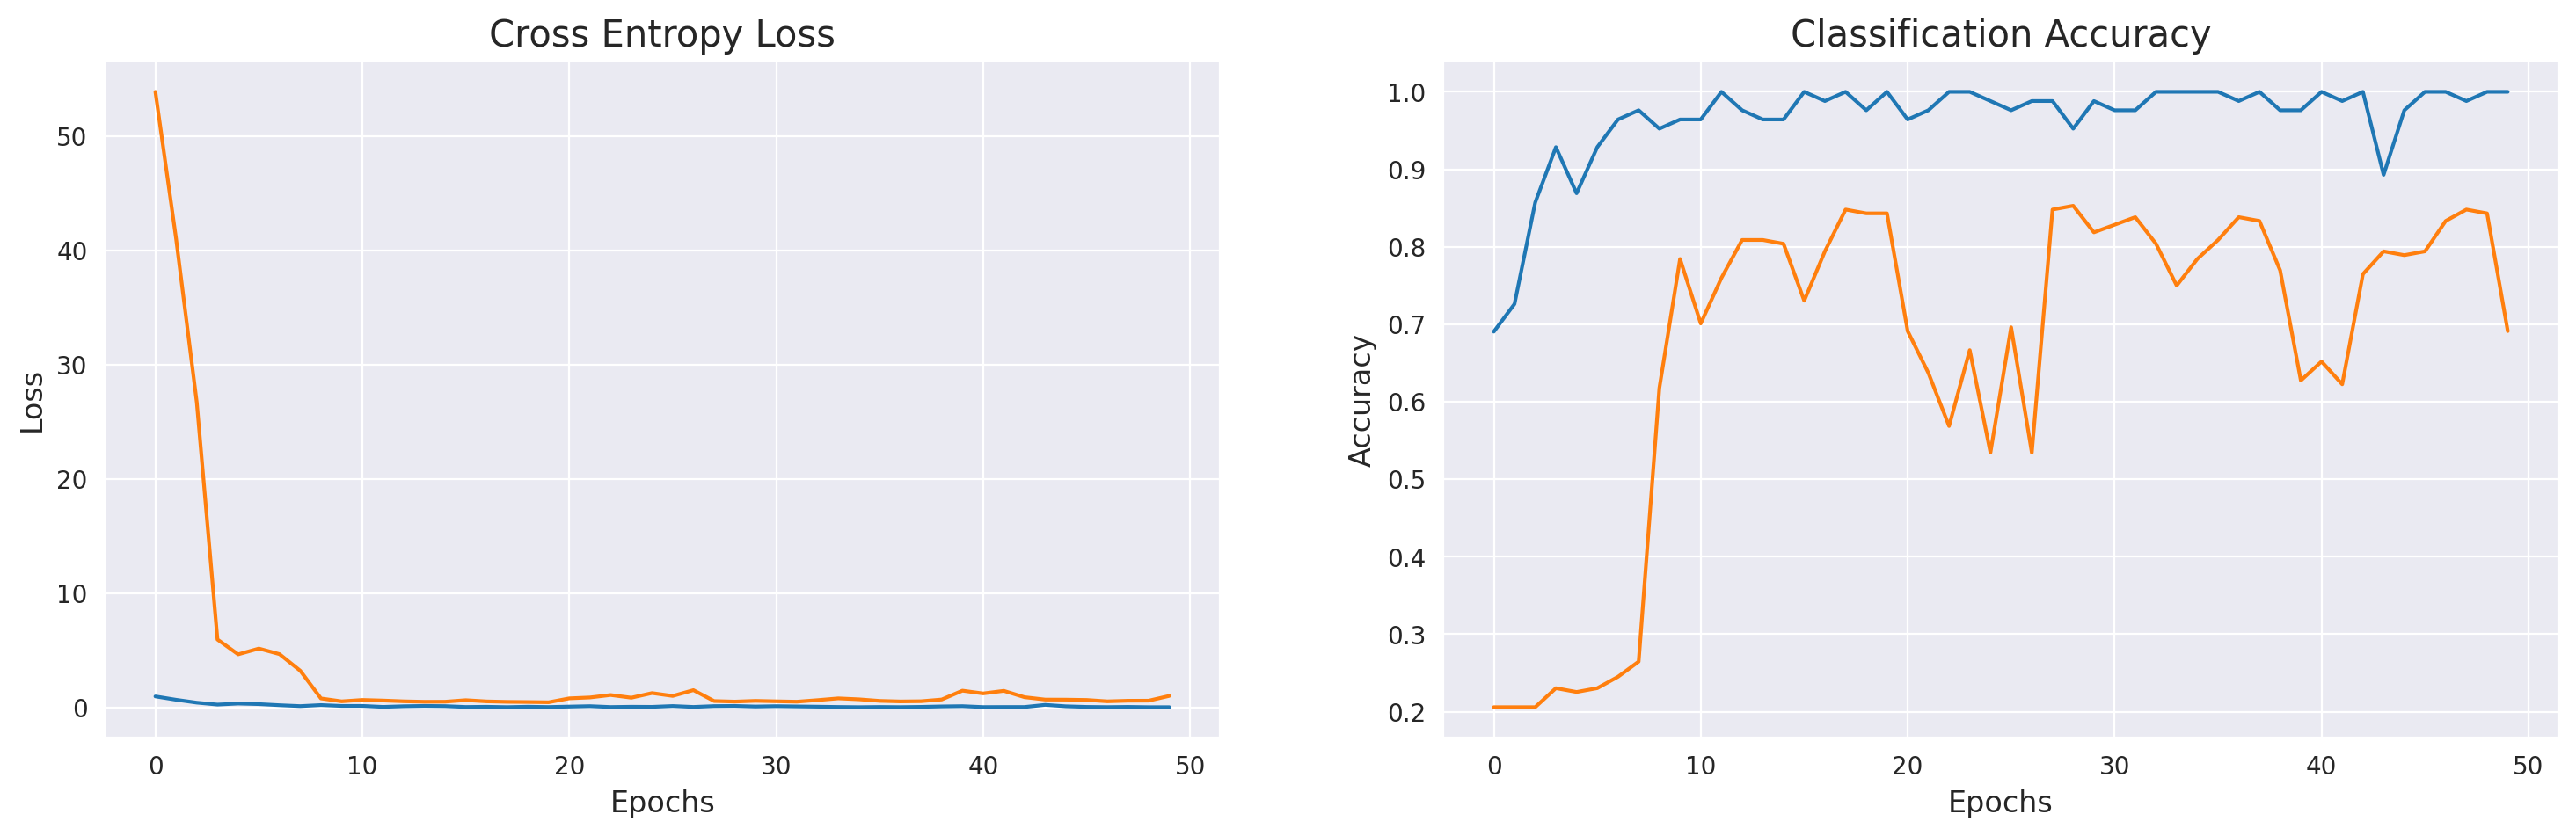

In [19]:
error = pd.DataFrame(history1.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

In [20]:
# prediction
result = model.predict(test_gen)

y_pred = np.argmax(result, axis = 1)

y_true = test_gen.labels

# Evaluvate
loss,acc = model.evaluate(test_gen)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6391 - loss: 1.3240
The accuracy of the model for testing data is: 69.11764740943909
The Loss of the model for testing data is: 1.0035741329193115


In [21]:
print(classification_report(y_true, y_pred,target_names=classes))

              precision    recall  f1-score   support

      Cancer       0.34      0.55      0.42        42
  Non_cancer       0.86      0.73      0.79       162

    accuracy                           0.69       204
   macro avg       0.60      0.64      0.61       204
weighted avg       0.75      0.69      0.71       204



Resnet50


In [22]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
model_resnet = Model(inputs=base_model.input, outputs=predictions)

In [24]:
model_resnet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
train_data_dir = '/content/New_Skin_Data_1/Training'
test_data_dir = '/content/New_Skin_Data_1/Testing'
batch_size = 16
img_size = (224, 224)
channels = 3

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                      target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                     target_size=img_size, class_mode='categorical',
                                     color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 84 validated image filenames belonging to 2 classes.
Found 204 validated image filenames belonging to 2 classes.


In [26]:
history_resnet = model_resnet.fit(train_gen,
                           validation_data=test_gen,
                           batch_size=64,
                           epochs=30)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 89s 6s/step - accuracy: 0.6159 - loss: 0.6602 - val_accuracy: 0.8137 - val_loss: 0.4428
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 402ms/step - accuracy: 0.9434 - loss: 0.1177 - val_accuracy: 0.8578 - val_loss: 0.3845
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 373ms/step - accuracy: 1.0000 - loss: 0.0156 - val_accuracy: 0.8578 - val_loss: 0.4477
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - accuracy: 0.9878 - loss: 0.0395 - val_accuracy: 0.8627 - val_loss: 0.3870
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - accuracy: 1.0000 - loss: 0.0321 - val_accuracy: 0.8431 - val_loss: 0.3935
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 0.8480 - val_loss: 0.4289
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 346ms/step - accuracy: 1.0000 - loss: 0.0080 - val_accuracy: 0.8627 - val_loss: 0.4408
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 383ms/step - accuracy: 1.0000 - loss: 0.0092 - val_accuracy: 0.8578 - val_loss: 

In [27]:
Er = []
np.append(history_resnet, Er)

array([<keras.src.callbacks.history.History object at 0x7cc9963a4110>],
      dtype=object)

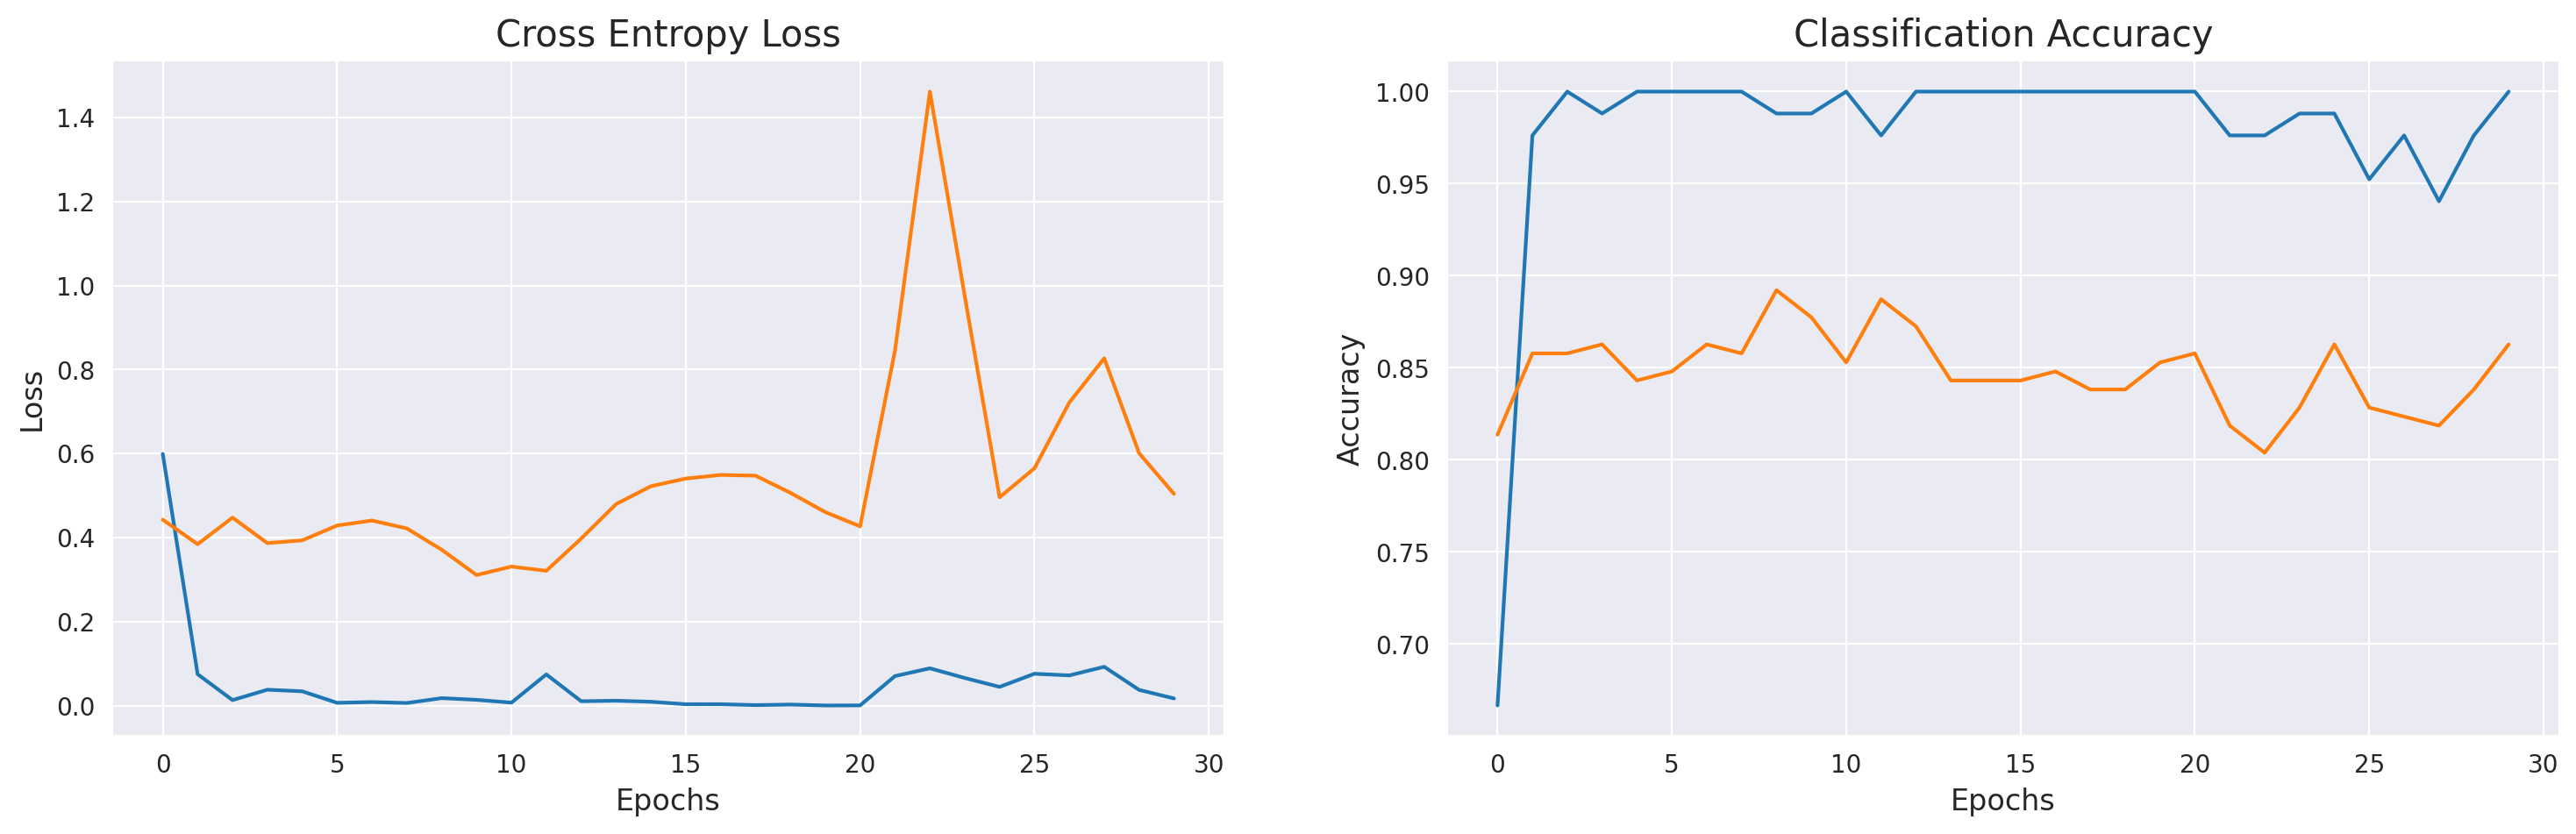

In [28]:
error_resnet = pd.DataFrame(history_resnet.history)

plt.figure(figsize=(18, 5), dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.plot(error_resnet['loss'])
plt.plot(error_resnet['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.plot(error_resnet['accuracy'])
plt.plot(error_resnet['val_accuracy'])

plt.show()

In [29]:
# Prediction
result = model_resnet.predict(test_gen)
y_pred = result.argmax(axis=1)
y_true = test_gen.labels

# Evaluvate
loss,acc = model_resnet.evaluate(test_gen)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 344ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7445 - loss: 0.9444
The accuracy of the model for testing data is: 86.27451062202454
The Loss of the model for testing data is: 0.5042404532432556


In [30]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_true, y_pred)
print('The Mean Squared Error (MSE) for the model is:', mse)


The Mean Squared Error (MSE) for the model is: 0.13725490196078433


In [31]:
# After training your model, save it to a file
model_resnet.save('skin_cancer_resnet_model_1.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
#model_resnet = load_model('/content/skin_cancer_resnet_model_1.h5')  # Replace 'your_model_path.h5' with the actual path to your saved model

In [ ]:
# import random
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import random
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Load the test data generator
# test_data_dir = '/kaggle/input/skin-cancer-image-classification/New_Skin_Data_1/Testing'  # Update with your test data path
# ts_gen = ImageDataGenerator(rescale=1./255)  # Normalize the test data
# test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
#                                      target_size=(224, 224), class_mode='categorical',
#                                      color_mode='rgb', shuffle=False, batch_size=1)

# # Get a random image and its label from the test dataset
# random_index = random.randint(0, len(test_gen) - 1)
# random_image, random_label = test_gen[random_index]

# # Make a prediction on the random image
# prediction = model_resnet.predict(random_image)[0]

# # Define class labels
# class_labels = ['Non_cancer', 'Cancer']

# # Get the predicted class and true class
# predicted_class = class_labels[np.argmax(prediction)]
# true_class = class_labels[np.argmax(random_label)]

# # Calculate accuracy
# accuracy = 1 if true_class == predicted_class else 0

# # Display the random image, the prediction, and the accuracy
# plt.imshow(random_image[0])  # No need to divide by 255 as rescaling is done in the generator
# plt.title(f'Predicted Class: {predicted_class}\nTrue Class: {true_class}\nAccuracy: {accuracy}')
# plt.show()


VGG16

In [33]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [34]:
# Load the pre-trained VGG16 model with ImageNet weights (excluding top classification layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [35]:
# Add custom layers on top of the VGG16 base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

In [36]:
# Create the new model with the custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [37]:
# Data directories and parameters
train_data_dir = '/content/New_Skin_Data_1/Training'
test_data_dir = '/content/New_Skin_Data_1/Testing'
batch_size = 16
img_size = (224, 224)
channels = 3

In [38]:
# Create data generators
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                      target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                     target_size=img_size, class_mode='categorical',
                                     color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 84 validated image filenames belonging to 2 classes.
Found 204 validated image filenames belonging to 2 classes.


In [39]:
# Train the model
history_vgg16 = model.fit(train_gen,
                         validation_data=test_gen,
                         batch_size=64,
                         epochs=30)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 56s 8s/step - accuracy: 0.5195 - loss: 2.2530 - val_accuracy: 0.2157 - val_loss: 1.1310
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 740ms/step - accuracy: 0.5397 - loss: 0.7745 - val_accuracy: 0.7941 - val_loss: 0.4621
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - accuracy: 0.4807 - loss: 0.9220 - val_accuracy: 0.7647 - val_loss: 0.6198
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 497ms/step - accuracy: 0.6477 - loss: 0.6370 - val_accuracy: 0.8137 - val_loss: 0.4858
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 737ms/step - accuracy: 0.6020 - loss: 0.7133 - val_accuracy: 0.2696 - val_loss: 0.9667
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - accuracy: 0.6072 - loss: 0.6464 - val_accuracy: 0.7941 - val_loss: 0.5764
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 536ms/step - accuracy: 0.5602 - loss: 0.6652 - val_accuracy: 0.6618 - val_loss: 0.6462
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 503ms/step - accuracy: 0.7055 - loss: 0.5943 - val_accuracy: 0.8284 - val_loss: 0

In [40]:
# Make predictions
result = model.predict(test_gen)
y_pred = result.argmax(axis=1)
y_true = test_gen.labels
# Evaluate
loss, acc = model.evaluate(test_gen)

print('The accuracy of the model for testing data is:', acc * 100)
print('The Loss of the model for testing data is:', loss)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.6157 - loss: 1.1135
The accuracy of the model for testing data is: 44.60784196853638
The Loss of the model for testing data is: 1.5353326797485352


In [41]:
Er = []
np.append(history_vgg16, Er)

array([<keras.src.callbacks.history.History object at 0x7cc8c606d7d0>],
      dtype=object)

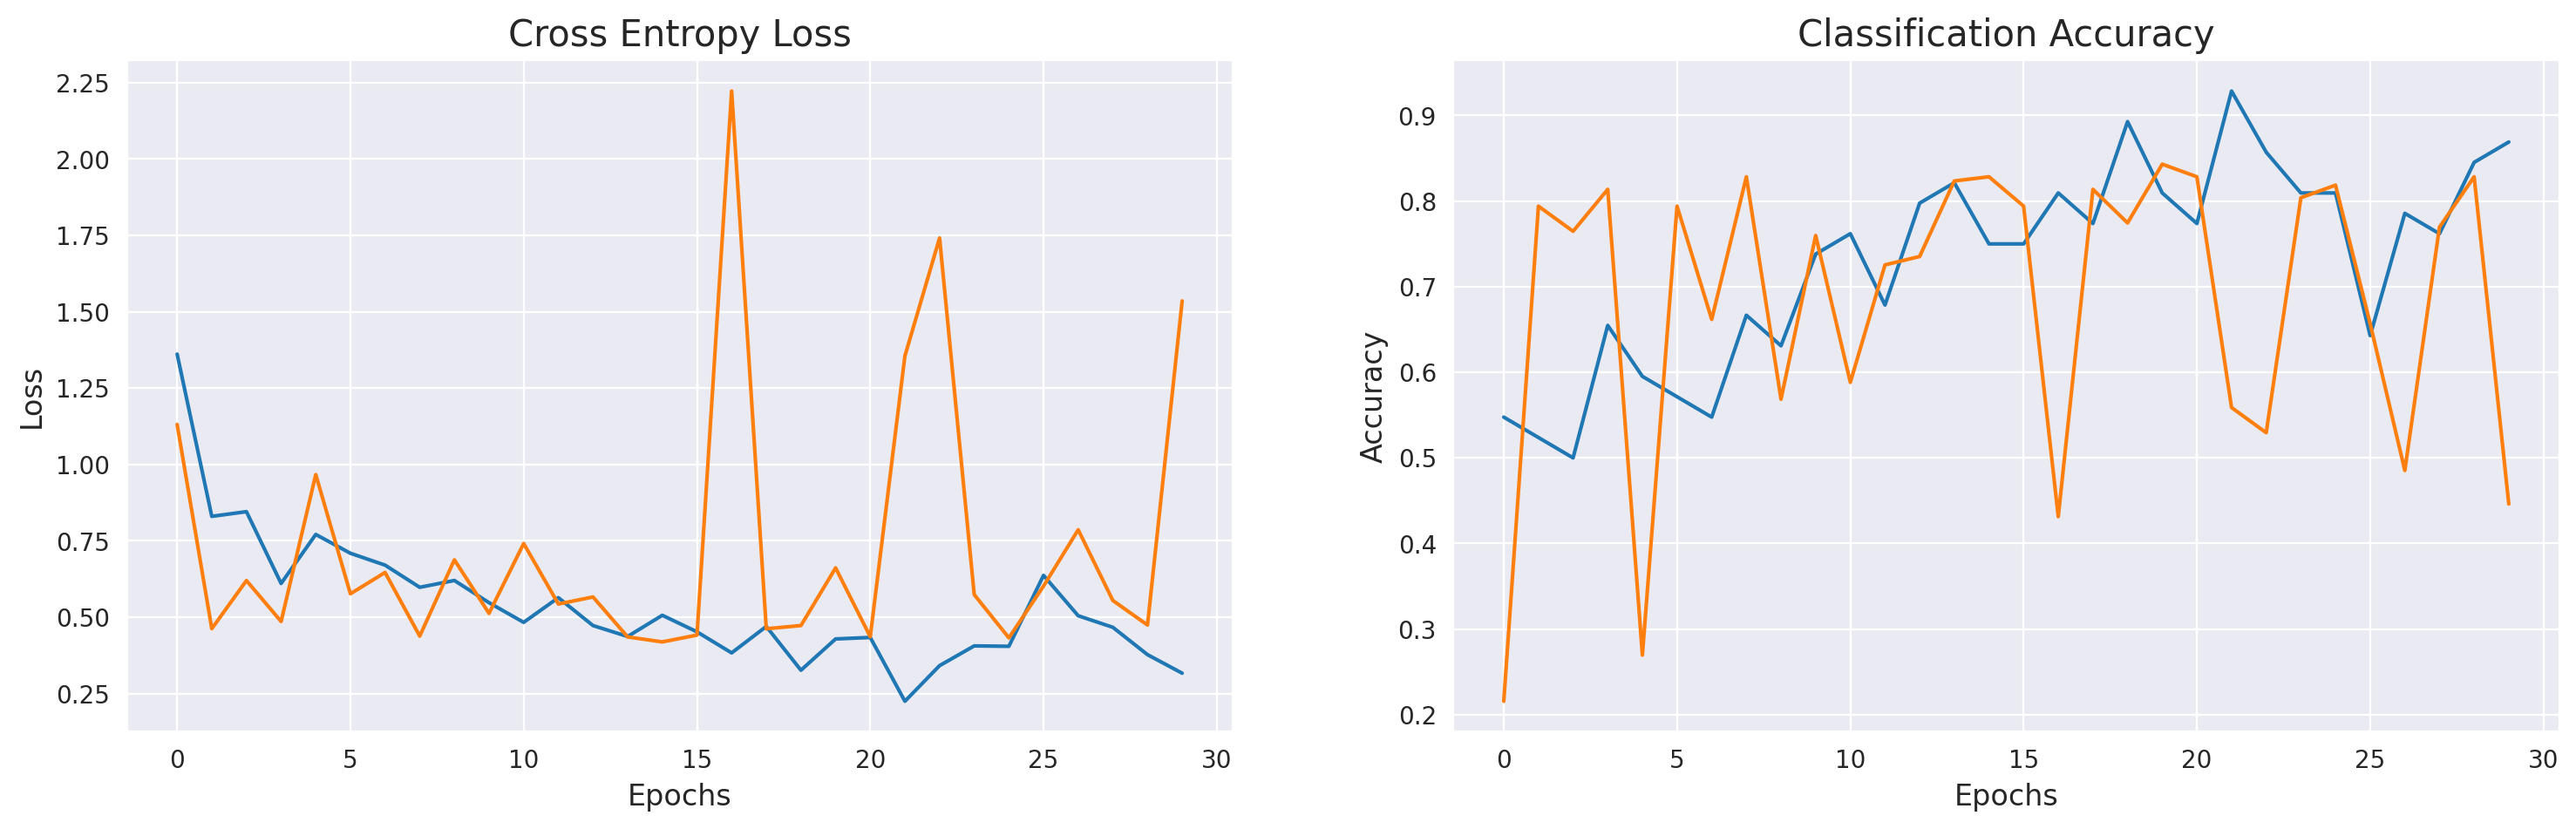

In [42]:
error_vgg16 = pd.DataFrame(history_vgg16.history)

plt.figure(figsize=(18, 5), dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.plot(error_vgg16['loss'])
plt.plot(error_vgg16['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.plot(error_vgg16['accuracy'])
plt.plot(error_vgg16['val_accuracy'])

plt.show()


In [43]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_true, y_pred)
print('The Mean Squared Error (MSE) for the model is:', mse)


The Mean Squared Error (MSE) for the model is: 0.553921568627451


In [9]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True  # Freeze layers

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [14]:
# Data directories and parameters
train_data_dir = '/content/New_Skin_Data_1/Training'
test_data_dir = '/content/New_Skin_Data_1/Testing'
batch_size = 16
img_size = (224, 224)
channels = 3

In [15]:
# Create data generators
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                      target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                     target_size=img_size, class_mode='categorical',
                                     color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 84 validated image filenames belonging to 2 classes.
Found 204 validated image filenames belonging to 2 classes.


In [16]:
# Train the model
history_EfficientNetB7 = model.fit(train_gen,
                         validation_data=test_gen,
                         batch_size=64,
                         epochs=30)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 505s 49s/step - accuracy: 0.5276 - loss: 0.7036 - val_accuracy: 0.7598 - val_loss: 0.6212
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 785ms/step - accuracy: 0.8249 - loss: 0.4187 - val_accuracy: 0.8431 - val_loss: 0.5140
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 929ms/step - accuracy: 0.9400 - loss: 0.3095 - val_accuracy: 0.8431 - val_loss: 0.4477
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 770ms/step - accuracy: 0.9945 - loss: 0.1929 - val_accuracy: 0.8382 - val_loss: 0.4038
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 780ms/step - accuracy: 1.0000 - loss: 0.1140 - val_accuracy: 0.8382 - val_loss: 0.3773
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 889ms/step - accuracy: 0.9806 - loss: 0.1659 - val_accuracy: 0.8529 - val_loss: 0.3587
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 796ms/step - accuracy: 1.0000 - loss: 0.0866 - val_accuracy: 0.8529 - val_loss: 0.3449
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 939ms/step - accuracy: 1.0000 - loss: 0.0336 - val_accuracy: 0.8480 - val_loss:

In [26]:
# Make predictions
result = model.predict(test_gen)
y_pred = result.argmax(axis=1)
y_true = test_gen.labels
# Evaluate
loss, acc = model.evaluate(test_gen)

print('The accuracy of the model for testing data is:', acc * 100)
print('The Loss of the model for testing data is:', loss)

13/13 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.8028 - loss: 0.3916
The accuracy of the model for testing data is: 86.76470518112183
The Loss of the model for testing data is: 0.2839462161064148


In [27]:
Er = []
np.append(history_EfficientNetB7, Er)

array([<keras.src.callbacks.history.History object at 0x7e19065fe510>],
      dtype=object)

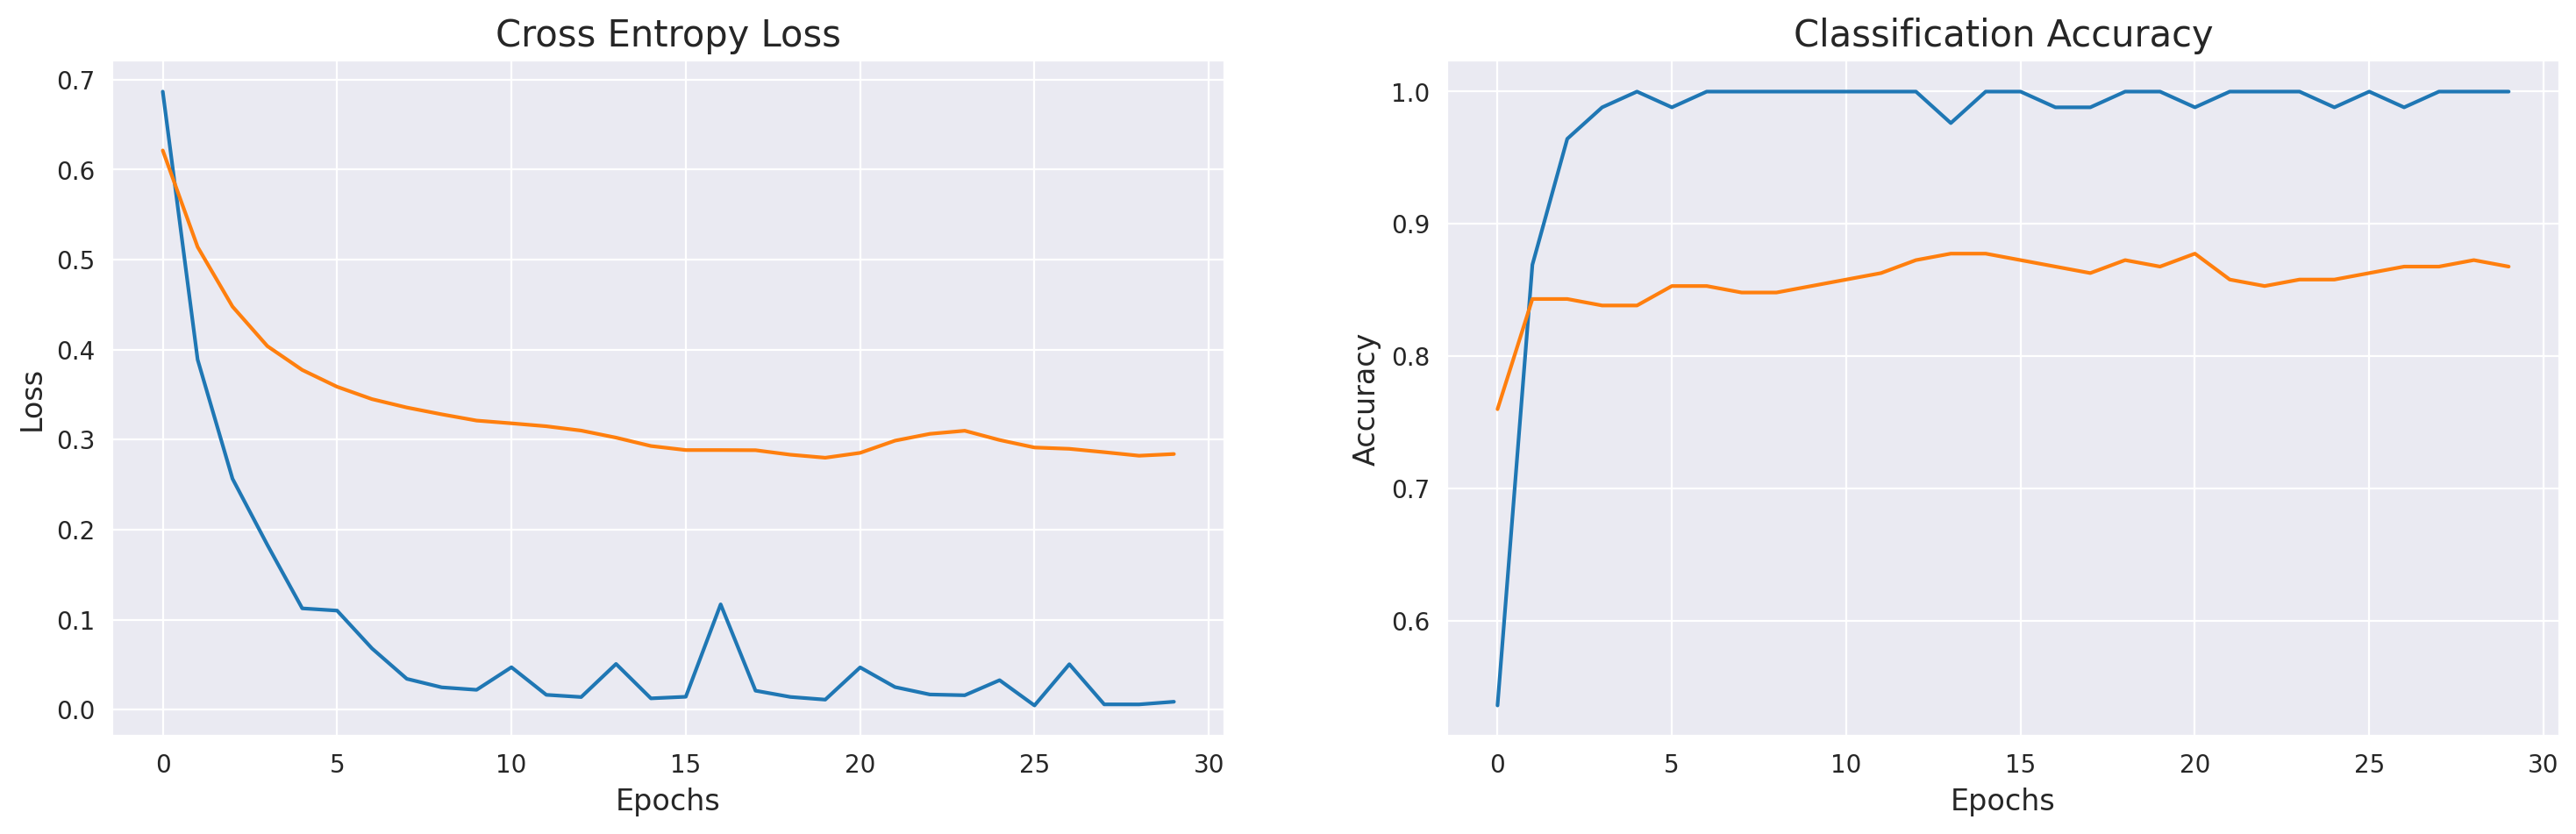

In [29]:
error_EfficB7 = pd.DataFrame(history_EfficientNetB7.history)

plt.figure(figsize=(18, 5), dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.plot(error_EfficB7['loss'])
plt.plot(error_EfficB7['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.plot(error_EfficB7['accuracy'])
plt.plot(error_EfficB7['val_accuracy'])

plt.show()

# EfficientNetB7 Model

In [17]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import numpy as np
import os

In [19]:
# Load base model without top
base_model = EfficientNetB7(include_top=False, weights='imagenet', input_shape=(600, 600, 3))

# Allow training for fine-tuning
base_model.trainable = True  # Enables fine-tuning

# Add GlobalAveragePooling2D to get feature vector
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Define model for feature extraction
feature_extractor_model = Model(inputs=base_model.input, outputs=x)

In [20]:
feature_extractor_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 600, 600,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 600, 600,  │          0 │ input_layer_6[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 600, 600,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 600, 600,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 601, 601,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 300, 300,  │      1,728 │ stem_conv_pad[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 300, 300,  │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 300, 300,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 300, 300,  │        576 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 300, 300,  │        256 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 300, 300,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 64)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 64)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 16)  │      1,040 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 64)  │      1,088 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 300, 300,  │          0 │ block1a_activati… │
│ (Multiply)          │ 64)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 300, 300,  │      2,048 │ block1a_se_excit

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 63,786,960 (243.33 MB)

 Non-trainable params: 310,727 (1.19 MB)

In [22]:
class FeatureExtractor:
    def __init__(self, input_shape=(600, 600, 3), batch_size=32):
        self.input_shape = input_shape
        self.batch_size = batch_size

        # Load EfficientNetB7 base model
        base_model = EfficientNetB7(
            include_top=False,
            weights='imagenet',
            input_shape=self.input_shape
        )

        # Enable training (for fine-tuning later)
        base_model.trainable = True

        # Add GlobalAveragePooling to get feature vector
        x = base_model.output
        x = GlobalAveragePooling2D()(x)

        # Create the feature extraction model
        self.model = Model(inputs=base_model.input, outputs=x)

        # Data generator with preprocessing
        self.datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    def extract(self, data_dir):
        # Load data from directory
        generator = self.datagen.flow_from_directory(
            data_dir,
            target_size=self.input_shape[:2],
            batch_size=self.batch_size,
            class_mode='sparse',
            shuffle=False
        )

        # Extract features
        features = self.model.predict(generator, verbose=1)

        # Get labels and class mapping
        labels = generator.classes
        class_map = generator.class_indices

        return features, labels, class_map

In [24]:
import os
import pandas as pd
import json

def extract_and_save_features(data_dir, output_dir, input_shape=(600, 600, 3), batch_size=32):
    # Create the output directory if it does not exist
    os.makedirs(output_dir, exist_ok=True)

    # Initialize the feature extractor
    extractor = FeatureExtractor(input_shape=input_shape, batch_size=batch_size)

    # Extract features and labels
    print("Extracting features from:", data_dir)
    features, labels, class_map = extractor.extract(data_dir)

    # Convert features to a DataFrame and append labels
    df_features = pd.DataFrame(features)
    df_features['label'] = labels

    # Define output paths
    csv_path = os.path.join(output_dir, 'extracted_features.csv')
    class_map_path = os.path.join(output_dir, 'class_mapping.json')

    # Save features to CSV
    df_features.to_csv(csv_path, index=False)
    print(f"Feature vectors saved to: {csv_path}")

    # Save class index mapping to JSON
    with open(class_map_path, 'w') as f:
        json.dump(class_map, f)
    print(f"Class mapping saved to: {class_map_path}")

In [25]:
extract_and_save_features(
    data_dir='/content/drive/MyDrive/C1_data/Training/',
    output_dir='/content/drive/MyDrive/C1_data/Extracted_Features/',
    input_shape=(600, 600, 3),
    batch_size=32
)

Extracting features from: /content/drive/MyDrive/C1_data/Training/
Found 84 images belonging to 2 classes.
3/3 ━━━━━━━━━━━━━━━━━━━━ 96s 21s/step
Feature vectors saved to: /content/drive/MyDrive/C1_data/Extracted_Features/extracted_features.csv
Class mapping saved to: /content/drive/MyDrive/C1_data/Extracted_Features/class_mapping.json
